In [1]:
# PRCP-1026 – Teaching Assistance: End-to-End Modeling Notebook (Classification)

1) Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
classification_report,
confusion_matrix,
accuracy_score,
f1_score,
precision_score,
recall_score,
ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

2) Load Dataset

In [2]:
df = pd.read_csv("tae.csv")

In [3]:
df

,1,23,3,1.1,19,3.1
0,2,15,3,1,17,3
1,1,23,3,2,49,3
2,1,5,2,2,33,3
3,2,7,11,2,55,3
4,2,23,3,1,20,3
...,...,...,...,...,...,...
145,2,3,2,2,26,1
146,2,10,3,2,12,1
147,1,18,7,2,48,1
148,2,22,1,2,51,1


In [22]:
rename_map = {
    '1': 'Native_teacher',
    '23': 'Instructor',
    '3': 'Course',
    '1.1': 'Semester',
    '19': 'Class_size',
    '3.1': 'Performance'
}

In [23]:
# Convert all to string in case pandas treats them as float column names
df.rename(columns={str(k): v for k,v in rename_map.items()}, inplace=True)

In [24]:
# Display basic info

In [25]:
print("Shape:", df.shape)

Shape: (150, 6)


In [26]:
df.head()

,Native_teacher,Instructor,Course,Semester,Class_size,Performance
0,2,15,3,1,17,3
1,1,23,3,2,49,3
2,1,5,2,2,33,3
3,2,7,11,2,55,3
4,2,23,3,1,20,3


In [27]:
df.tail()

,Native_teacher,Instructor,Course,Semester,Class_size,Performance
145,2,3,2,2,26,1
146,2,10,3,2,12,1
147,1,18,7,2,48,1
148,2,22,1,2,51,1
149,2,2,10,2,27,1


In [28]:
df.columns

Index(['Native_teacher', 'Instructor', 'Course', 'Semester', 'Class_size',
       'Performance'],
      dtype='object')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Native_teacher  150 non-null    int64
 1   Instructor      150 non-null    int64
 2   Course          150 non-null    int64
 3   Semester        150 non-null    int64
 4   Class_size      150 non-null    int64
 5   Performance     150 non-null    int64
dtypes: int64(6)
memory usage: 7.2 KB


In [30]:
df.describe()

,Native_teacher,Instructor,Course,Semester,Class_size,Performance
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.813333,13.580000,8.140000,1.853333,27.926667,2.013333
std,0.390949,6.805318,7.034937,0.354958,12.916405,0.819123
min,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000
25%,2.000000,8.000000,3.000000,2.000000,19.000000,1.000000
50%,2.000000,13.000000,4.500000,2.000000,27.000000,2.000000
75%,2.000000,20.000000,15.000000,2.000000,37.000000,3.000000
max,2.000000,25.000000,26.000000,2.000000,66.000000,3.000000


3) Exploratory Data Analysis (EDA)

In [31]:
# Goal: Understand dataset, spot issues, find patterns

In [32]:
# --- Missing Values ---
print("Missing values per column:", df.isna().sum())

Missing values per column: Native_teacher    0
Instructor        0
Course            0
Semester          0
Class_size        0
Performance       0
dtype: int64


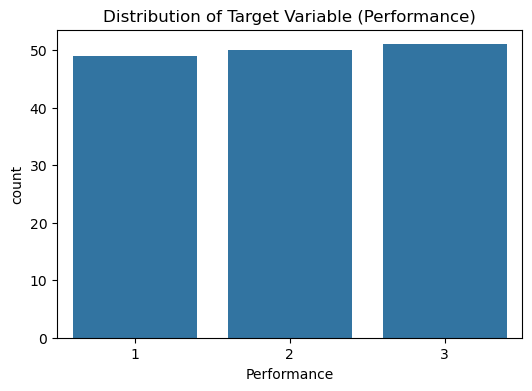

In [33]:
# --- Distribution of the Target Variable (Performance) ---
plt.figure(figsize=(6,4))
sns.countplot(x='Performance', data=df)
plt.title("Distribution of Target Variable (Performance)")
plt.show()

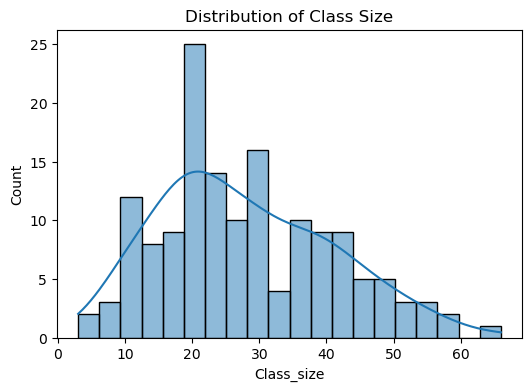

In [34]:
# --- Distribution of Class Size ---
plt.figure(figsize=(6,4))
sns.histplot(df['Class_size'], bins=20, kde=True)
plt.title("Distribution of Class Size")
plt.show()


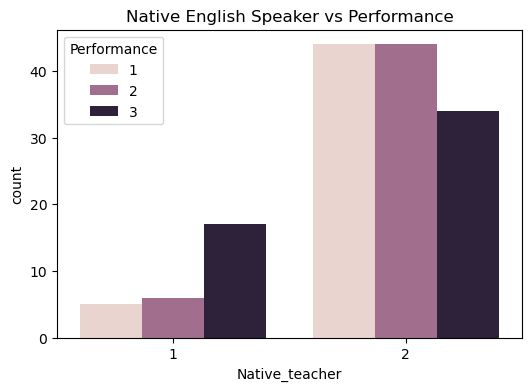

In [35]:
# --- Relationship: Native Teacher vs Performance ---
plt.figure(figsize=(6,4))
sns.countplot(x='Native_teacher', hue='Performance', data=df)
plt.title("Native English Speaker vs Performance")
plt.show()

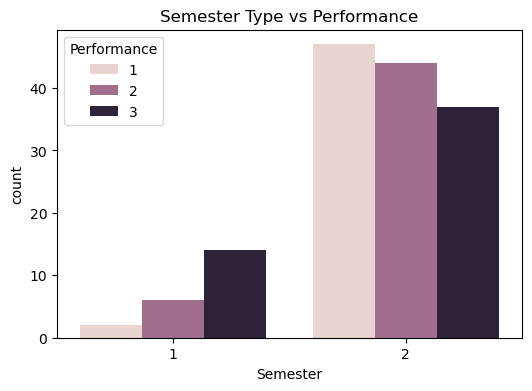

In [36]:
# --- Relationship: Semester vs Performance ---
plt.figure(figsize=(6,4))
sns.countplot(x='Semester', hue='Performance', data=df)
plt.title("Semester Type vs Performance")
plt.show()

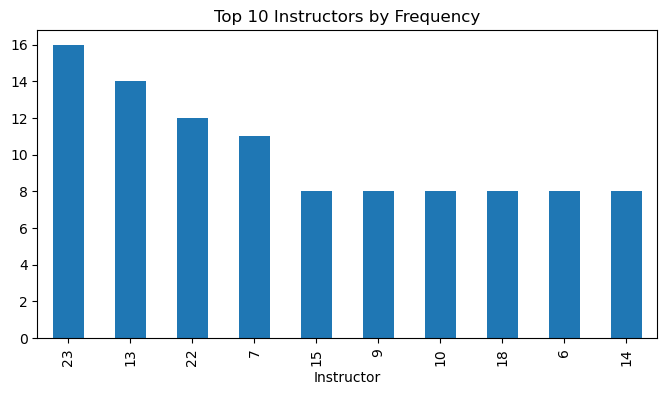

In [37]:
# --- Instructor Frequency (Top 10) ---
plt.figure(figsize=(8,4))
df['Instructor'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Instructors by Frequency")
plt.show()

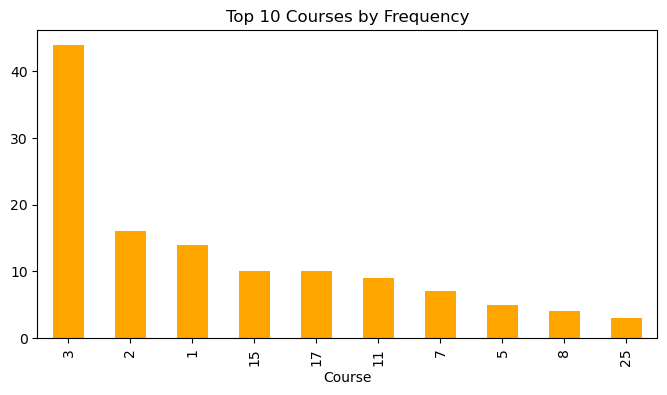

In [38]:
# --- Course Frequency (Top 10) ---
plt.figure(figsize=(8,4))
df['Course'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 Courses by Frequency")
plt.show()

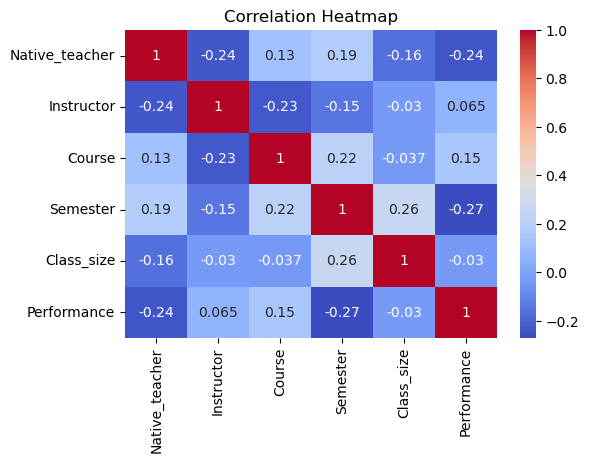

In [39]:
# --- Correlation Heatmap for Numeric Features ---
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

4) Preprocessing Setup

In [42]:
TARGET = 'Performance'
X = df.drop(columns=[TARGET])
y = df[TARGET]

categorical_cols = ['Native_teacher', 'Instructor', 'Course', 'Semester']
numeric_cols = ['Class_size']

In [43]:
# Pipeline: encode categorical variables and scale numeric ones
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ], remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

5) Logistic Regression Model

In [44]:
log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight='balanced'))
])

param_log_reg = {'model__C': [0.1, 1.0, 10.0]}

log_reg_grid = GridSearchCV(log_reg, param_log_reg, cv=cv, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Native_teacher',
                                                                          'Instructor',
                                                                          'Course',
                                                                          'Semester']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Class_size'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000))]),
             n_jobs=-1, param_grid={'model__C': [0.1, 1.0, 10.0]},
             scoring='accuracy')


=== Logistic Regression ===
Best Params: {'model__C': 10.0}
Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.40      0.36        10
           2       0.45      0.50      0.48        10
           3       0.57      0.40      0.47        10

    accuracy                           0.43        30
   macro avg       0.45      0.43      0.44        30
weighted avg       0.45      0.43      0.44        30



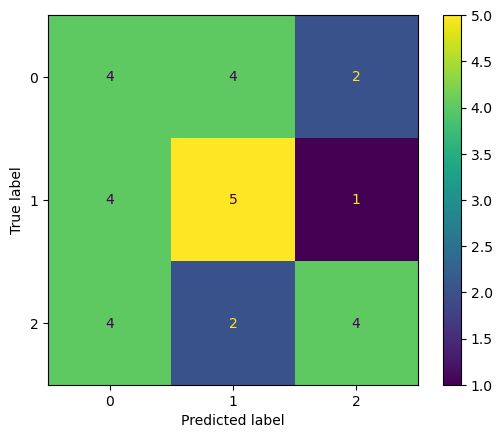

In [45]:
# Evaluate Logistic Regression
y_pred = log_reg_grid.predict(X_test)
print("\n=== Logistic Regression ===")
print("Best Params:", log_reg_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot(values_format='d')
plt.show()

6) Decision Tree Model

In [46]:
dt = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

param_dt = {'model__max_depth': [None, 3, 5, 8]}

dt_grid = GridSearchCV(dt, param_dt, cv=cv, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Native_teacher',
                                                                          'Instructor',
                                                                          'Course',
                                                                          'Semester']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Class_size'])])),
                                       ('model',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1, param_grid={'model__max_depth': [None, 3, 5, 8]},
             scoring='accuracy')


=== Decision Tree ===
Best Params: {'model__max_depth': None}
Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.60      0.60        10
           2       0.46      0.60      0.52        10
           3       0.71      0.50      0.59        10

    accuracy                           0.57        30
   macro avg       0.59      0.57      0.57        30
weighted avg       0.59      0.57      0.57        30



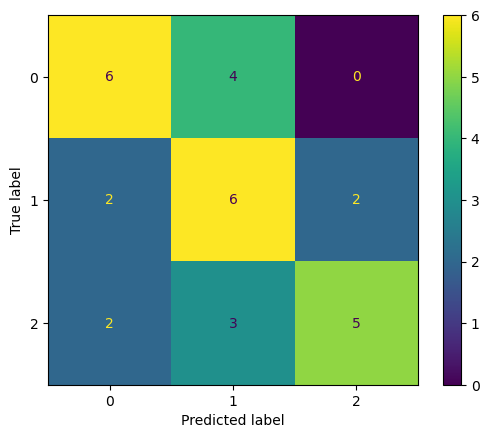

In [47]:
# Evaluate Decision Tree
y_pred = dt_grid.predict(X_test)
print("\n=== Decision Tree ===")
print("Best Params:", dt_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot(values_format='d')
plt.show()

7) Random Forest Model

In [48]:
rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_rf = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [None, 5, 10]
}

rf_grid = GridSearchCV(rf, param_rf, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Native_teacher',
                                                                          'Instructor',
                                                                          'Course',
                                                                          'Semester']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Class_size'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 5, 10],
                         'model__n_estimators': [100, 300]},
             scoring='accuracy')


=== Random Forest ===
Best Params: {'model__max_depth': 10, 'model__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.60      0.60        10
           2       0.50      0.60      0.55        10
           3       0.75      0.60      0.67        10

    accuracy                           0.60        30
   macro avg       0.62      0.60      0.60        30
weighted avg       0.62      0.60      0.60        30



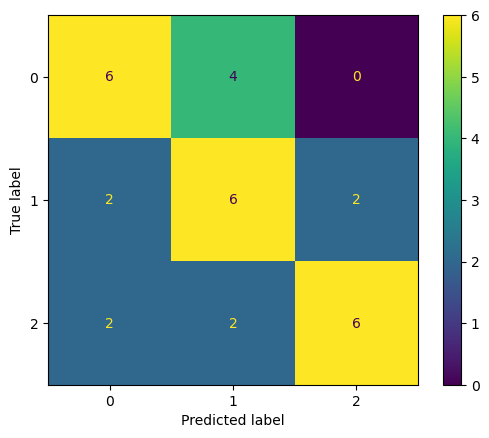

In [49]:
# Evaluate Random Forest
y_pred = rf_grid.predict(X_test)
print("\n=== Random Forest ===")
print("Best Params:", rf_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot(values_format='d')
plt.show()

8) Support Vector Classifier (SVC) Model

In [50]:
svc = Pipeline([
    ("preprocess", preprocess),
    ("model", SVC(probability=True, class_weight='balanced', random_state=42))
])

param_svc = {
    'model__C': [0.5, 1.0, 5.0],
    'model__kernel': ['rbf', 'linear']
}

svc_grid = GridSearchCV(svc, param_svc, cv=cv, scoring='accuracy', n_jobs=-1)
svc_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Native_teacher',
                                                                          'Instructor',
                                                                          'Course',
                                                                          'Semester']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Class_size'])])),
                                       ('model',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.5, 1.0, 5.0],
                         'model__kernel': ['rbf', 'linear']},
             scoring='accuracy')


=== SVC ===
Best Params: {'model__C': 5.0, 'model__kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.70      0.64        10
           2       0.45      0.50      0.48        10
           3       0.71      0.50      0.59        10

    accuracy                           0.57        30
   macro avg       0.58      0.57      0.57        30
weighted avg       0.58      0.57      0.57        30



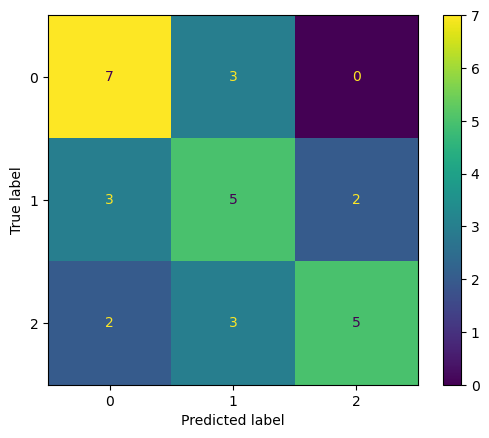

In [51]:
# Evaluate SVC
y_pred = svc_grid.predict(X_test)
print("\n=== SVC ===")
print("Best Params:", svc_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot(values_format='d')
plt.show()

9) Compare Models


MODEL COMPARISON:
                  Model  Best CV Accuracy  Test Accuracy      F1  Precision  \
2        Random Forest            0.6667         0.6000  0.6040     0.6167   
1        Decision Tree            0.6167         0.5667  0.5700     0.5919   
3                  SVC            0.5667         0.5667  0.5669     0.5841   
0  Logistic Regression            0.5833         0.4333  0.4368     0.4531   

   Recall  
2  0.6000  
1  0.5667  
3  0.5667  
0  0.4333  


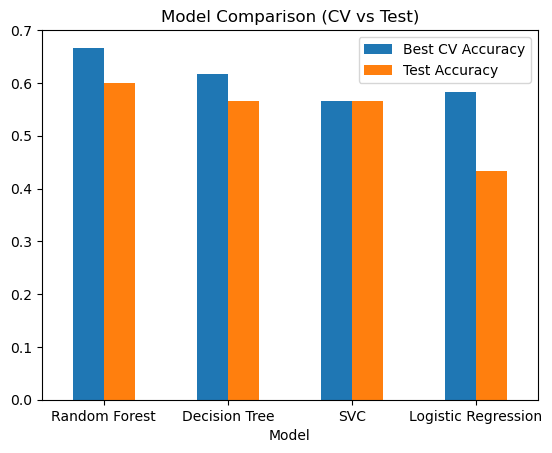

In [52]:
results = []

for name, grid in zip(
    ["Logistic Regression", "Decision Tree", "Random Forest", "SVC"],
    [log_reg_grid, dt_grid, rf_grid, svc_grid]
):
    y_pred = grid.predict(X_test)
    results.append({
        'Model': name,
        'Best CV Accuracy': round(grid.best_score_, 4),
        'Test Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'F1': round(f1_score(y_test, y_pred, average='weighted'), 4),
        'Precision': round(precision_score(y_test, y_pred, average='weighted', zero_division=0), 4),
        'Recall': round(recall_score(y_test, y_pred, average='weighted'), 4)
    })

results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
print("\nMODEL COMPARISON:\n", results_df)

results_df.plot(x='Model', y=['Best CV Accuracy','Test Accuracy'], kind='bar')
plt.title('Model Comparison (CV vs Test)')
plt.xticks(rotation=0)
plt.show()